In [108]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import math

%matplotlib inline

#Get familiar with the data

make sure ES is up and running

In [9]:
res = requests.get('http://elasticsearch-events.fal.zenit.io:9200/',auth=(eslogin.user,eslogin.password))
print(res.content)

{
  "status" : 200,
  "name" : "es02.fal.zenit.io",
  "cluster_name" : "zenit-events",
  "version" : {
    "number" : "1.5.2",
    "build_hash" : "62ff9868b4c8a0c45860bebb259e21980778ab1c",
    "build_timestamp" : "2015-04-27T09:21:06Z",
    "build_snapshot" : false,
    "lucene_version" : "4.10.4"
  },
  "tagline" : "You Know, for Search"
}



connect to the cluster

In [13]:
#import elasticsearch 

es = Elasticsearch([{'host': 'elasticsearch-events.fal.zenit.io', 'port': 9200}],http_auth=('zenit','6nAzJGhq'))

do some searching

In [43]:
result = es.search(index="events-2015.06.06", body={'query': {'match': { 'et' : 'AD_CLICK' }}}, size = 2)

In [44]:
print json.dumps(result, indent=2)

{
  "hits": {
    "hits": [
      {
        "_score": 8.113712, 
        "_type": "AD_CLICK", 
        "_id": "AU3ImJ3vy-bsL55W3_co", 
        "_source": {
          "ci": null, 
          "co": "ITA", 
          "ai": 67, 
          "ip": "62.98.84.76", 
          "ak": 130, 
          "pbep": 70, 
          "vw_drtn": 0, 
          "cr": 331, 
          "et": "AD_CLICK", 
          "id": "zenit_925f99a4-fb81-4f5a-9df6-f45de05fb5c5_331", 
          "plfm": "android", 
          "pp": 0, 
          "pv": "4.4.4", 
          "li": 212, 
          "pg": 0, 
          "rgn": "ITA-04", 
          "fr": false, 
          "vw_perc": 0, 
          "ernc": 0, 
          "ssp": "zenit_marketplace", 
          "br": "Chrome 43.0.2357.92", 
          "dt": "android", 
          "arch": false, 
          "lidp": 0, 
          "dp": 0, 
          "cvpc": 1500000, 
          "sdpt": 0, 
          "created_at": "2015-06-06T11:19:14.665Z", 
          "isp": "Wind Telecomunicazioni", 
          "cty": 

It seems to work!

the structure of result (JSON) is a python dictionary:

In [16]:
result.keys()

[u'hits', u'_shards', u'took', u'timed_out']

In [17]:
result['hits'].keys()

[u'hits', u'total', u'max_score']

In [18]:
len(result['hits']['hits'])

10

But it only shows 10/103 hits... (6/6/15)
Can consider the following way to get more data:
https://www.elastic.co/guide/en/elasticsearch/guide/current/pagination.html
https://elasticsearch-py.readthedocs.org/en/master/api.html#elasticsearch.Elasticsearch.search

In [19]:
es.count(index="events-2015.06.06", body={'query': {'match': { 'et' : 'AD_CLICK' }}})['count']

103

In [20]:
es.count(index="events-2015.06.06", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

84

Note: true needs to be 'true' in Python API here

In [21]:
result = es.search(index="events-2015.06.06", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, size = 84)

In [61]:
result['hits']['hits'][0]

{u'_id': u'AU3ImJ3vy-bsL55W3_co',
 u'_index': u'events-2015.06.06',
 u'_score': 8.113712,
 u'_source': {u'ai': 67,
  u'ak': 130,
  u'arch': False,
  u'br': u'Chrome 43.0.2357.92',
  u'ci': None,
  u'co': u'ITA',
  u'cr': 331,
  u'created_at': u'2015-06-06T11:19:14.665Z',
  u'cty': u'Naples',
  u'cvpc': 1500000,
  u'dp': 0,
  u'dt': u'android',
  u'ernc': 0,
  u'et': u'AD_CLICK',
  u'fr': False,
  u'id': u'zenit_925f99a4-fb81-4f5a-9df6-f45de05fb5c5_331',
  u'ip': u'62.98.84.76',
  u'isp': u'Wind Telecomunicazioni',
  u'li': 212,
  u'lidp': 0,
  u'pbep': 70,
  u'pg': 0,
  u'plfm': u'android',
  u'pp': 0,
  u'pv': u'4.4.4',
  u'rgn': u'ITA-04',
  u'sdpt': 0,
  u'ssp': u'zenit_marketplace',
  u'ua': u'Mozilla/5.0 (Linux; Android 4.4.4; SM-A300FU Build/KTU84P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.92 Mobile Safari/537.36',
  u'vw_drtn': 0,
  u'vw_perc': 0},
 u'_type': u'AD_CLICK'}

Convert to python pandas dataframe

In [39]:
df1 = pd.DataFrame([datum for datum in result['hits']['hits']])

In [40]:
df2 = pd.DataFrame([datum for datum in Table1['_source']])

In [46]:
merge = pd.concat([df1, df2], axis=1)

Examine each column and looks like I do not need to add df1 for now (most information can be found in df2, just except for "id" which I do not understand now.

# Download all "click" data

In [63]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2015-06-08 16:37:02'

Count the number of valid clicks so far

In [65]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

8961

In [66]:
clicks = es.search(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}}, size = 8961)

In [77]:
clicks_df = pd.DataFrame([datum['_source'] for datum in clicks['hits']['hits']])

In [78]:
clicks_df.shape

(8961, 46)

In [81]:
clicks_df.to_csv("clicks_150608.tab",sep='\t',encoding='utf-8')

Examine each column - each potential feature

In [86]:
len(clicks_df.columns.values)

46

# 46 columns:

## 0 'ai', 
## 1 'ak',    — APP KEY
## 2 'arch', — ARCHIVED
## 3 'au',    — AD UNIT TYPE
## 4 'br',    — BROWSER
## 5 'ci',     — CAMPAIGN ID
## 6 'cn',    — CONNECTION
## 7 'co',    — COUNTRY ISO3
## 8 'cr',     — CREATIVE ID
## 9 'created_at',
## 10 'cty',   — CITY
## 11 'curl',  — CLICK URL
## 12 'cvpc',— CONVERSION PRICE CENTS
## 13 'di',
## 14 'dnt', — DO NOT TRACK
## 15 'dp',  — DELIVERY PRICE CENTS
## 16 'dt',   — DEVICE TYPE
## 17 'ek',   — EXCHANGE KEY
## 18 'ernc',— EARNINGS CENTS
## 19 'et',    — EVENT TYPE
## 20 'ex',
## 21 'fr',    — FRAUD
## 22 'id',    — AD DELIVERY TOKEN
## 23 'ip',    — REMOTE IP
## 24 'isp',
## 25 'js',    — JS VERSION
## 26 'la',    — LANGUAGE
## 27 'li',     — LINE ITEM ID
## 28 'lidp', — LINE ITEM DISCOUNT PERCENT
## 29 'ma',   — MAC ADDRESS
## 30 'pb',   — PINGBACK
## 31 'pbep',— PUBLISHER EARNINGS PERCENT
## 32 'pg',   — PAGE
## 33 plfm', — PLATFORM
## 34 'pp',   — PER PAGE
## 35 'pv',   — PLATFORM VERSION
## 36 'rgn',  — REGION
## 37 'sdpt',— SESSION DEPTH
## 38 'si',    — SESSION ID
## 39 'ssp', — SUPPLY SIDE PLATFORM
## 40 'sv',   — SDK VERSION
## 41 'ua',   — USER AGENT
## 42 'uid',
## 43 'vt',    — VIEWER TOKEN
## 44 'vw_drtn',   — VIEWABILITY DURATION
## 45 'vw_perc'   — VIEWABILITY PERCENT

In [200]:
pd.options.display.max_rows = 3
pd.options.display.max_columns = 50
clicks_df

,ai,ak,arch,au,br,ci,cn,co,cr,created_at,cty,curl,cvpc,di,dnt,dp,dt,ek,ernc,et,ex,fr,id,ip,isp,js,la,li,lidp,ma,pb,pbep,pg,plfm,pp,pv,rgn,sdpt,si,ssp,sv,ua,uid,vt,vw_drtn,vw_perc
0,51,124,False,NaN,Other 0.0,103,NaN,GBR,157,2015-05-10T04:41:11.915Z,Eastbourne,NaN,NaN,NaN,NaN,300000,other,NaN,210000,AD_CLICK,NaN,False,zenit_d7dccf46-0e71-4b35-b682-6f66329de8ef_157,5.80.244.135,BT,NaN,NaN,85,0,NaN,NaN,70,0,None,0,unknown,GBR-E2,1,NaN,zenit_marketplace,NaN,Chelsea/4.5.1 CFNetwork/711.3.18 Darwin/14.0.0,56545422-1F56-4D29-BB75-2B6B9CE58C80,NaN,0,0
1,67,130,False,NaN,Android 4.0,NaN,NaN,ITA,218,2015-05-10T20:52:50.992Z,Massafra,NaN,NaN,NaN,NaN,0,android,NaN,0,AD_CLICK,NaN,False,zenit_b5826dcd-edf9-4b68-b835-4762b6c23eb4_218,2.226.115.192,Fastweb,NaN,NaN,130,0,NaN,NaN,70,0,android,0,4.4.4,ITA-13,0,NaN,zenit_marketplace,NaN,Mozilla/5.0 (Linux; U; Android 4.4.4; it-it; S...,NaN,NaN,0,0
2,93,143,False,NaN,Other 0.0,NaN,NaN,USA,222,2015-05-12T17:55:12.568Z,Mountain View,NaN,NaN,NaN,NaN,0,other,NaN,0,AD_CLICK,NaN,False,zenit_eaf4cdea-dc29-4bd7-81e8-e71c071a0870_222,66.249.78.238,Googlebot,NaN,NaN,133,0,NaN,NaN,70,0,None,0,unknown,USA-CA,0,NaN,zenit_marketplace,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


array([[<matplotlib.axes.AxesSubplot object at 0x7fda4b4ada50>]], dtype=object)

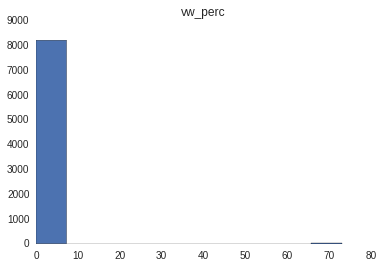

In [202]:
#plot_ind = [0, 2, 5, 8, 12, 15, 18, 21, 27, 28, 31, 32, 34, 37, 44, 45]

clicks_df[[45]].hist()

Make subset of the dataframe excluding the features that do not make sense for now OR not seem to be important OR too many NAN...

In [203]:
clicks_df_small = clicks_df[['ai','ak','br','co','cr','created_at','cty','dp','dt','ernc','isp','li','lidp','pbep','plfm','rgn','sdpt','ssp','ua','vw_drtn','vw_perc']]

In [204]:
clicks_df_small.shape

(8961, 21)